In [1]:
import numpy as np
from numpy import linalg as LA
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
from tqdm import *
%matplotlib inline

In [2]:
def loadData():
    dataList = []
    with open('faithful.dat','r') as faithfulFile:
        for line in faithfulFile:
            LineClip = line.rstrip().split()
            if len(LineClip) == 3:
                try:
                    dataList.append(list(map(float,LineClip[1:3]))) #extract the numbers and convert to float
                except:
                    pass
    dataMat = np.array(dataList)
    dataMatNorm = np.zeros(dataMat.shape)
    plt.figure()
    plt.scatter(dataMat[:,0],dataMat[:,1])
    plt.title('unnormalized data')
    #normalization for both features
    meanErupt = np.mean(dataMat[:,0])
    meanWait = np.mean(dataMat[:,1])
    varErupt = np.std(dataMat[:,0])
    varWait = np.std(dataMat[:,1])

    dataMatNorm[:,0] = (dataMat[:,0]-np.mean(dataMat[:,0]))/np.std(dataMat[:,0])
    dataMatNorm[:,1] = (dataMat[:,1]-np.mean(dataMat[:,1]))/np.std(dataMat[:,1])
    plt.figure()
    plt.scatter(dataMatNorm[:,0],dataMatNorm[:,1])
    plt.title('normalized data')
    return dataMatNorm

In [3]:
class GM_Model:
    def __init__(self):
        pass
    def responsibilityCal(self,data):
        stdCluster1 = np.sqrt(self.covCluster1)
        stdCluster2 = np.sqrt(self.covCluster2)
        responsibility = np.zeros(data.shape[0])
        for i in range(data.shape[0]):
            #calculate p.d.f. for the data for the normal distributions for both cluster accordingly
            densityCluster1 = multivariate_normal.pdf(data[i,:],self.meanCluster1,stdCluster1)
            densityCluster2 = multivariate_normal.pdf(data[i,:],self.meanCluster2,stdCluster2)
            responsibility[i] = self.prb*densityCluster2/((1-self.prb)*densityCluster1+self.prb*densityCluster2)  
        return responsibility
    def updateParams(self,responsibility,data):
        self.meanCluster1 = (1-responsibility).dot(data)/np.sum(1-responsibility)
        self.covCluster1 = (1-responsibility).dot((data-self.meanCluster1)**2)/np.sum(1-responsibility)
        self.meanCluster2 = responsibility.dot(data)/np.sum(responsibility)
        self.covCluster2 = responsibility.dot((data-self.meanCluster1)**2)/np.sum(responsibility)
        self.prb = np.sum(responsibility)/data.shape[0]
    def initialParamsRand(self):
        #initial guess of the parameters from random
        self.meanCluster1 = np.random.rand(2)
        self.meanCluster2 = np.random.rand(2)
        self.covCluster1 = np.absolute(np.random.rand(2)) 
        self.covCluster2 = np.absolute(np.random.rand(2))
        self.prb = np.random.rand()
    def initialParamsKMeans(self,dataMatNorm):
        kmeans = KMeans(n_clusters=2, random_state=0).fit(dataMatNorm) #fit kmeans
        initMeans = kmeans.cluster_centers_ #use cluster centers as initial means
        self.meanCluster1 = initMeans[0]
        self.meanCluster2 = initMeans[1]
        labels = kmeans.labels_
        count2 = labels.tolist().count(1)
        self.prb = count2/len(labels) #estimate piror by counting and calculating percentage
        index1 = np.where(labels == 0)[0] #find the indexes of cluster 1
        dataMatNorm_1 = dataMatNorm[index1] #extract data in cluster 1
        index2 = np.where(labels == 1)[0] #find the indexes of cluster 2
        dataMatNorm_2 = dataMatNorm[index1] #extract data in cluster 2
        self.covCluster1 = np.var(dataMatNorm_1,0) #use cluster variance as initial var
        self.covCluster2 = np.var(dataMatNorm_2,0) 
    def EM_iteration(self,dataMatNorm):
        mean1List = [self.meanCluster1] #initial the list of means for cluster 1, each component is an array of len 2
        mean2List = [self.meanCluster2] #initial the list of means for cluster 2, each component is an array of len 2
        responsibility = self.responsibilityCal(dataMatNorm) # calculate the responsibility
        self.updateParams(responsibility,dataMatNorm) #update the params with the responsibility
        mean1List.append(self.meanCluster1) 
        mean2List.append(self.meanCluster2)
        count = 0 #count number of iterations needed for converge
        threshold = 10**(-8) #threshold to assert convergence
        #compare the threshold to the L-2 norm of the difference between the params before and after update
        while LA.norm(mean1List[-1]-mean1List[-2])>threshold and LA.norm(mean2List[-1]-mean2List[-2])>threshold:
            self.updateParams(self.responsibilityCal(dataMatNorm),dataMatNorm)
            mean1List.append(self.meanCluster1)
            mean2List.append(self.meanCluster2)
            count += 1
        mean1List = np.array(mean1List) #convert to matrix
        mean2List = np.array(mean2List)
        return mean1List, mean2List, count

In [4]:
def massiveTrials(trials):
    countList = np.zeros(trials)
    for ind in tqdm(range(trials)):
        initialState = GM_Model()
        initialState.initialParamsRand()
        mean1List,mean2List, countList[ind] = initialState.EM_iteration(dataMatNorm)
    fig = plt.figure()
    plt.hist(countList)

In [5]:
def singleTrial(initMethod):
    initialState = GM_Model()
    #initialize the parameters randomly or by kmeans
    if initMethod is 'random':
        initialState.initialParamsRand()
    elif initMethod is 'kmeans':
        initialState.initialParamsKMeans(dataMatNorm)
    else:
        print('invaild method!')
    mean1List,mean2List,count = initialState.EM_iteration(dataMatNorm)
    #plotting trajectories
    plt.figure()
    plt.scatter(dataMatNorm[:,0],dataMatNorm[:,1])
    plt.plot(mean1List[:,0],mean1List[:,1],'r-')
    plt.plot(mean2List[:,0],mean2List[:,1],'y-')
    #plotting convergence with iterations
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(np.arange(count+2), mean1List[:,0], mean1List[:,1],'b-', label="cluster 1")
    ax.plot(np.arange(count+2), mean2List[:,0], mean2List[:,1],'g-', label="cluster 2")
    plt.xlabel('iterations')

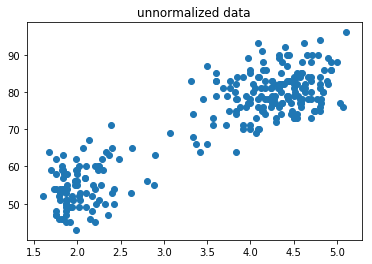

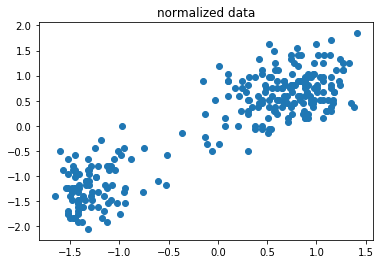

In [6]:
dataMatNorm = loadData()
#load data and normalize

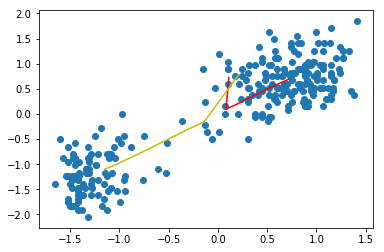

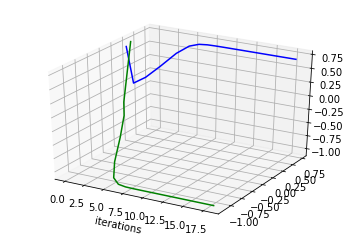

In [7]:
singleTrial('random') 
#randomly initialize
#show the trajectories of converging means and the change with iterations

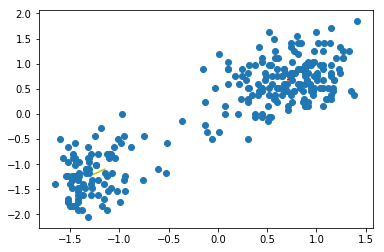

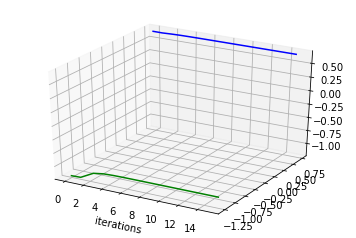

In [8]:
singleTrial('kmeans') 
#initialize with kmeans
#show the trajectories of converging means and the change with iterations

100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


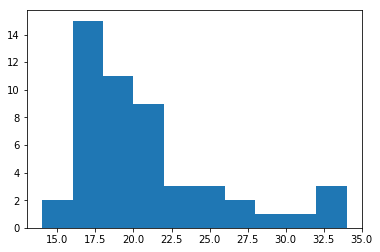

In [9]:
trialNum = 50
massiveTrials(trialNum)
#randomly initialize and run for 'trialNum' times to see the distribution of convergence speed
#shows the distribution of iterations needed to converge